# Imports

In [ ]:
import numpy as np
import pandas as pd



In [ ]:
!pip install git+https://github.com/huggingface/transformers.git@main

  Cloning https://github.com/huggingface/transformers.git (to revision main) to /tmp/pip-req-build-wcqmfs61
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-wcqmfs61
  Resolved https://github.com/huggingface/transformers.git to commit 43bfd093e1817c0333a1e10fcbdd54f1032baad0
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
!pip install -q datasets


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.8 MB/s eta 0:00:00


# Pulling data from GCP bucket

In [ ]:
from google.colab import auth
auth.authenticate_user()

# Set your project ID and the path to your credentials JSON file
project_id = 'ac215-project-398320'
credentials_file_path = 'data_service_account.json'

# Set the environment variable for the credentials file path
%env GOOGLE_APPLICATION_CREDENTIALS $credentials_file_path

env: GOOGLE_APPLICATION_CREDENTIALS=data_service_account.json


In [ ]:
from google.cloud import storage
import io

In [ ]:
# Initialize Google Cloud Storage client
client = storage.Client()

# Define your GCS bucket name and CSV file path
bucket_name = 'instacap-data'
file_path = 'sample_dataset.csv'

# Get the GCS bucket and blob
bucket = client.get_bucket(bucket_name)
blob = bucket.blob(file_path)

# Download the CSV file as a string
csv_data = blob.download_as_text()

# Download labels CSV from GCP bucket
df = pd.read_csv(io.StringIO(csv_data))

# Now you have your data in a Pandas DataFrame (df)
print(df.head())

                    image_file_name  \
0  mbinkowski56_1371758583406805957   
1  mbinkowski56_1487192047675809173   
2  mbinkowski56_2359243140974887720   
3  mbinkowski56_2467214337921873767   
4  mbinkowski56_2608504269023064708   

                                             caption  
0                                    How much Sauce?  
1       Chapter 1/4. Thanks for a great season guys.  
2                                         Sending it  
3  WARNING  EMERGENCY EXIT ONLY  DO NOT OPEN DOOR...  
4  “Fambily, Frends, and Freezeepops.”- Christoph...  


In [ ]:
from datasets import Dataset

In [ ]:
dataset = Dataset.from_pandas(df)

In [ ]:
type(dataset)

datasets.arrow_dataset.Dataset

In [ ]:
dataset['image_file_name'][:5]

['mbinkowski56_1371758583406805957',
 'mbinkowski56_1487192047675809173',
 'mbinkowski56_2359243140974887720',
 'mbinkowski56_2467214337921873767',
 'mbinkowski56_2608504269023064708']

In [ ]:
dataset['caption'][:5]

['How much Sauce?',
 'Chapter 1/4. Thanks for a great season guys.',
 'Sending it',
 'WARNING  EMERGENCY EXIT ONLY  DO NOT OPEN DOOR  ALARM WILL SOUND',
 '“Fambily, Frends, and Freezeepops.”- Christopher Walken']

In [ ]:
from google.cloud import storage
import pandas as pd
from PIL import Image
import io



# Initialize an empty list to store the dictionaries
data_list = []

# Iterate through DataFrame rows
for index, row in df.iterrows():
    image_filename = row['image_file_name']  # Assuming this is the column name for image file names
    caption = row['caption']  # Assuming this is the column name for captions

    # Get image blob and download image data
    image_blob = bucket.blob('posts/' + image_filename)
    image_data = image_blob.download_as_bytes()

    # Open image using PIL
    image = Image.open(io.BytesIO(image_data))

    # Create dictionary and append to the list
    data_dict = {
        'image': image,
        'caption': caption
    }
    data_list.append(data_dict)

# Now, data_list contains the dictionaries in the desired format
print(data_list)


[{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256 at 0x7BE1C8233010>, 'caption': 'How much Sauce?'}, {'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256 at 0x7BE1C2B0FA30>, 'caption': 'Chapter 1/4. Thanks for a great season guys.'}, {'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256 at 0x7BE1C2BB14E0>, 'caption': 'Sending it'}, {'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256 at 0x7BE1C8230850>, 'caption': 'WARNING  EMERGENCY EXIT ONLY  DO NOT OPEN DOOR  ALARM WILL SOUND'}, {'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256 at 0x7BE1C2BB1990>, 'caption': '“Fambily, Frends, and Freezeepops.”- Christopher Walken'}, {'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256 at 0x7BE1C2BB1B40>, 'caption': 'Summer of Sixies™️'}, {'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256 at 0x7BE1C2BB1AE0>, 'caption': 'Whatever is true, whatever is hono

In [ ]:
from datasets import load_dataset

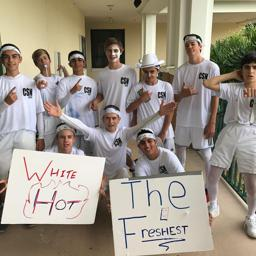

In [ ]:
data_list[0]['image']

In [ ]:
from torch.utils.data import Dataset, DataLoader

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = self.processor(images=item["image"], text=item["caption"], padding="max_length", return_tensors="pt")
        # remove batch dimension
        encoding = {k:v.squeeze() for k,v in encoding.items()}
        return encoding

In [ ]:
from transformers import AutoProcessor, BlipForConditionalGeneration

processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

In [ ]:
# splitting our dataset:
n = len(data_list)
train_size = 0.8
train_data = data_list[:int(train_size*n)]
test_data = data_list[int(train_size*n):]

In [ ]:
train_data

[{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256>,
  'caption': 'How much Sauce?'},
 {'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256>,
  'caption': 'Chapter 1/4. Thanks for a great season guys.'},
 {'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256>,
  'caption': 'Sending it'},
 {'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256>,
  'caption': 'WARNING  EMERGENCY EXIT ONLY  DO NOT OPEN DOOR  ALARM WILL SOUND'},
 {'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256>,
  'caption': '“Fambily, Frends, and Freezeepops.”- Christopher Walken'},
 {'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256>,
  'caption': 'Summer of Sixies™️'},
 {'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256>,
  'caption': 'Whatever is true, whatever is honorable, whatever is just, whatever is pure, whatever is lovely, whatever is commendable, if there is any ex

In [ ]:
test_data[1]['caption']

'This is my commandment, that you love one another as I have loved you.\n\n\u202d\u202dJohn\u202c \u202d15\u202c:\u202d12\u202c'

In [ ]:
train_dataset = ImageCaptioningDataset(train_data, processor)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=2)

In [ ]:
import torch

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()

for epoch in range(5):
  print("Epoch:", epoch)
  for idx, batch in enumerate(train_dataloader):
    input_ids = batch.pop("input_ids").to(device)
    pixel_values = batch.pop("pixel_values").to(device)

    outputs = model(input_ids=input_ids,
                    pixel_values=pixel_values,
                    labels=input_ids)

    loss = outputs.loss

    print("Loss:", loss.item())

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

Epoch: 0


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Loss: 13.195073127746582
Loss: 10.407553672790527
Loss: 10.282387733459473
Loss: 10.106303215026855
Epoch: 1
Loss: 10.281723022460938
Loss: 10.236053466796875
Loss: 10.116926193237305
Loss: 10.195985794067383
Epoch: 2
Loss: 10.073447227478027
Loss: 10.22024154663086
Loss: 10.168803215026855
Loss: 10.10328483581543
Epoch: 3
Loss: 10.093522071838379
Loss: 9.827796936035156
Loss: 9.348859786987305
Loss: 8.826549530029297
Epoch: 4
Loss: 8.876605033874512
Loss: 8.604061126708984
Loss: 8.580692291259766
Loss: 8.395120620727539


In [ ]:
test_data

[{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256>,
  'caption': 'For it is God who works in you, both to will and to work for his good pleasure.\n\n\u202d\u202dPhp\u202c \u202d2\u202c:\u202d13\u202c'},
 {'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256>,
  'caption': 'This is my commandment, that you love one another as I have loved you.\n\n\u202d\u202dJohn\u202c \u202d15\u202c:\u202d12\u202c'}]

In [ ]:
image = test_data[0]['image']

inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

a picture of a person in a suit


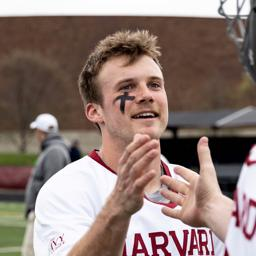

In [ ]:
image

In [ ]:
pretrained_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")
pre_generated_ids = pretrained_model.generate(pixel_values=pixel_values, max_length=50)
pre_generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(pre_generated_caption)

a picture of a person in a suit
